# LSTM on Donors Choose dataset -  Model-2

In [1]:
from google.colab import drive
drive.flush_and_unmount()

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [1]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
!pip install -U tensorboardcolab
!pip install -U tensorboard
!pip install keras-tqdm
import datetime
from tensorboardcolab import *
from scipy.sparse import hstack
from sklearn.utils import compute_class_weight
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, concatenate, Flatten, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from keras_tqdm import TQDMCallback
from tensorboardcolab import *
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)
Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.3.0)


## Reading Data

In [2]:
data = pd.read_csv('/content/drive/My Drive/LSTM/processed_data.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data.head(3)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,digits_in_project_summary,processed_titles,processed_essays,processed_summary
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,154.60,23,0,educational support english learners home,students english learners working english seco...,students need opportunities practice beginning...
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,299.00,1,0,wanted projector hungry learners,students arrive school eager learn polite gene...,students need projector help viewing education...
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,516.85,22,0,soccer equipment awesome middle school students,true champions not always ones win guts mia ha...,students need shine guards athletic socks socc...


In [3]:
data['total_text'] = data['processed_essays'].map(str) +\
                    ' ' + data['processed_titles'].map(str) +\
                    ' ' + data['processed_summary'].map(str)

data = data.drop(['processed_essays','processed_titles','processed_summary'], axis=1)
data.head(3)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,digits_in_project_summary,total_text
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,154.60,23,0,students english learners working english seco...
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,299.00,1,0,students arrive school eager learn polite gene...
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,516.85,22,0,true champions not always ones win guts mia ha...


In [4]:
X = data.drop(['project_is_approved'], axis=1)
Y = data['project_is_approved']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=0)

In [6]:
print('Train Data Set', x_train.shape, y_train.shape)
print('Test Data Set', x_test.shape, y_test.shape)
print('Validation Data Set', x_val.shape, y_val.shape)

Train Data Set (61178, 10) (61178,)
Test Data Set (32775, 10) (32775,)
Validation Data Set (15295, 10) (15295,)


In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# computing class weights
class_weights = compute_class_weight("balanced", classes= np.unique(Y),y=Y)

## TFIDF vectorizer on text data

In [9]:
vectorizer = TfidfVectorizer(min_df=2)

train_tfidf_text = vectorizer.fit_transform(x_train['total_text'])
                                            
tfidf_dict = dict(zip(vectorizer.get_feature_names(),list(vectorizer.idf_)))
tfidf_df = pd.DataFrame(tfidf_dict.items(), columns=['words','idf_values'])
tfidf_df.shape

(29028, 2)

In [10]:
# getting the min and max values
print(tfidf_df.idf_values.max())
print(tfidf_df.idf_values.min())

10.922946983692347
1.0


Text(0.5, 1.0, 'BOX plot of idf_values')

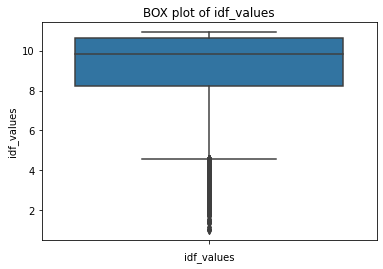

In [11]:
sns.boxplot(y = "idf_values", data = tfidf_df)
plt.xlabel("idf_values")
plt.title("BOX plot of idf_values")

In [12]:
print("1st percentile: ", np.percentile(tfidf_df['idf_values'],1))
print("10th percentile: ", np.percentile(tfidf_df['idf_values'],10))
print("25th percentile: ", np.percentile(tfidf_df['idf_values'],25))
print("50th percentile: ", np.percentile(tfidf_df['idf_values'],50))
print("75th percentile: ", np.percentile(tfidf_df['idf_values'],75))
print("90th percentile: ", np.percentile(tfidf_df['idf_values'],90))

1st percentile:  3.6065782681311322
10th percentile:  6.496106333228673
25th percentile:  8.214896782590138
50th percentile:  9.824334695024238
75th percentile:  10.635264911240567
90th percentile:  10.922946983692347


__The 75th and 90th percentile values are almost equal and the 90th percentile is the max value__

__we will select tfidf values from 1st percentile till 75th percentile i.e we will remove lower and higher tfidf values__

In [13]:
tfidf_qdf = tfidf_df[(tfidf_df["idf_values"] >=  np.percentile(tfidf_df['idf_values'],1)) & (tfidf_df["idf_values"] <=  np.percentile(tfidf_df['idf_values'],75))]

In [14]:
tfidf_qdf.shape

(23303, 2)

Text(0.5, 1.0, 'BOX plot of idf_values')

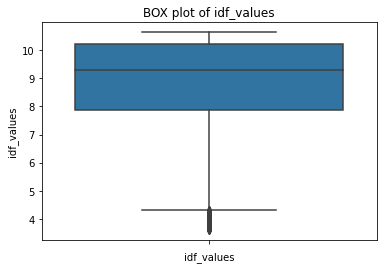

In [15]:
sns.boxplot(y = "idf_values", data = tfidf_qdf)
plt.xlabel("idf_values")
plt.title("BOX plot of idf_values")

## Encoding Text Data

In [16]:
def encoding_padding(input_text, max_length):
    encoded_data = tokenizer.texts_to_sequences(input_text)
    padded_data = pad_sequences(encoded_data, maxlen=max_length, padding='post')
    return padded_data

In [17]:
train_text = x_train["total_text"].values.tolist()
test_text = x_test['total_text'].values.tolist()
val_text = x_val['total_text'].values.tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tfidf_qdf['words'].values.tolist())
vocab_size = len(tokenizer.word_index) + 1

max_length = len(max(data["total_text"], key=len).split(' '))
train_text_encode = encoding_padding(train_text,  max_length=max_length)
test_text_encode = encoding_padding(test_text, max_length=max_length)
val_text_encode = encoding_padding(val_text, max_length=max_length)

print(train_text_encode.shape)
print(test_text_encode.shape)
print(val_text_encode.shape)

(61178, 334)
(32775, 334)
(15295, 334)


In [18]:
glove_vector = open("/content/drive/My Drive/LSTM/glove_vectors","rb")
glove_words = pickle.load(glove_vector)

In [19]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
print(embedding_matrix.shape)
embedding_matrix[10]

(23304, 300)


array([-5.2563e-01, -8.1471e-02, -8.7679e-02,  3.6250e-01,  2.5145e-01,
        2.5332e-01, -7.2741e-01, -1.2895e-01, -2.2463e-01,  4.1395e-01,
       -1.8628e-01,  7.5147e-01, -5.1474e-02, -2.0533e-01,  2.0896e-01,
        2.1953e-01,  7.1992e-02, -7.2084e-02,  1.2473e-01,  1.0072e-01,
        4.3089e-01, -2.2556e-01,  4.0336e-01,  1.0675e-01, -1.5874e-01,
        1.9817e-02, -1.1831e-01,  1.5472e-01,  1.0124e-01,  4.7343e-01,
       -1.1340e-01,  3.9872e-02,  1.3537e-01,  3.8088e-01,  7.4135e-04,
       -2.0583e-01, -1.4896e-01, -3.3975e-01,  1.8002e-01,  3.1978e-01,
        4.7128e-01, -2.1962e-01,  1.7118e-02,  3.2690e-02,  3.7092e-01,
        3.8507e-01,  2.8598e-01,  6.2181e-04, -4.7049e-01, -2.2392e-01,
        2.4061e-01,  5.7028e-02, -4.6002e-01, -6.5060e-02, -2.8102e-01,
       -4.8228e-01,  7.7486e-03, -2.9416e-01,  5.1761e-01, -1.0215e-01,
        2.3103e-01,  2.9073e-02,  1.2966e-01,  5.5421e-01,  4.3397e-01,
        1.1786e-01,  1.4393e-01,  3.7729e-01,  9.6626e-02,  2.03

In [21]:
input_text = Input(shape=(train_text_encode.shape[1],), name='input_text')

x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_text')(input_text)
x1 = LSTM(128,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Encoding Categorical features

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["teacher_prefix"].values.tolist())

no_unique_prefix  = x_train["teacher_prefix"].nunique()
embed_prefix_size = int(min(np.ceil((no_unique_prefix)/2+1), 50 ))
print('Unique Categories:', no_unique_prefix,'Embedding Size:', embed_prefix_size)

print('-'*50)

input_prefix = Input(shape=(1,),name="teacher_prefix")
x2 = Embedding(input_dim=no_unique_prefix+1, output_dim=embed_prefix_size+1, name="embed_prefix", trainable=True)(input_prefix)
layer_2 = Flatten()(x2)

train_prefix_encode = encoding_padding(x_train["teacher_prefix"], max_length=1)
test_prefix_encode = encoding_padding(x_test["teacher_prefix"], max_length=1)
val_prefix_encode = encoding_padding(x_val["teacher_prefix"], max_length=1)

print(train_prefix_encode.shape)
print(test_prefix_encode.shape)
print(val_prefix_encode.shape)

Unique Categories: 5 Embedding Size: 4
--------------------------------------------------
(61178, 1)
(32775, 1)
(15295, 1)


In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["school_state"].values.tolist())

no_unique_state  = x_train["school_state"].nunique()
embed_state_size = int(min(np.ceil((no_unique_state)/2+1), 50 ))
print('Unique Categories:', no_unique_state,'Embedding Size:', embed_state_size)

print('-'*50)

input_state = Input(shape=(1,),name="school_state")
x3 = Embedding(input_dim=no_unique_state+1, output_dim=embed_state_size+1, name="embed_state", trainable=True)(input_state)
layer_3 = Flatten()(x3)

train_state_encode = encoding_padding(x_train["school_state"], max_length=1)
test_state_encode = encoding_padding(x_test["school_state"], max_length=1)
val_state_encode = encoding_padding(x_val["school_state"], max_length=1)

print(train_state_encode.shape)
print(test_state_encode.shape)
print(val_state_encode.shape)

Unique Categories: 51 Embedding Size: 27
--------------------------------------------------
(61178, 1)
(32775, 1)
(15295, 1)


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["project_grade_category"].values.tolist())

no_unique_grade  = x_train["project_grade_category"].nunique()
embed_grade_size = int(min(np.ceil((no_unique_grade)/2+1), 50 ))
print('Unique Categories:', no_unique_grade,'Embedding Size:', embed_grade_size)

print('-'*50)

input_grade = Input(shape=(1,),name="grade")
x4 = Embedding(input_dim=no_unique_grade+1, output_dim=embed_grade_size+1, name="embed_grade", trainable=True)(input_grade)
layer_4 = Flatten()(x4)

train_grade_encode = encoding_padding(x_train["project_grade_category"], max_length=1)
test_grade_encode = encoding_padding(x_test["project_grade_category"], max_length=1)
val_grade_encode = encoding_padding(x_val["project_grade_category"], max_length=1)

print(train_grade_encode.shape)
print(test_grade_encode.shape)
print(val_grade_encode.shape)

Unique Categories: 4 Embedding Size: 3
--------------------------------------------------
(61178, 1)
(32775, 1)
(15295, 1)


In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["project_subject_categories"].values.tolist())

no_unique_cat  = x_train["project_subject_categories"].nunique()
embed_cat_size = int(min(np.ceil((no_unique_cat)/2+1), 50 ))
print('Unique Categories:', no_unique_cat ,'Embedding Size:', embed_cat_size)

print('-'*50)

input_cat= Input(shape=(1,),name="subject_categories")
x5 = Embedding(input_dim=no_unique_cat+1, output_dim=embed_cat_size+1, name="embed_cat", trainable=True)(input_cat)
layer_5 = Flatten()(x5)

train_cat_encode = encoding_padding(x_train["project_subject_categories"], max_length=1)
test_cat_encode = encoding_padding(x_test["project_subject_categories"], max_length=1)
val_cat_encode = encoding_padding(x_val["project_subject_categories"], max_length=1)

print(train_cat_encode.shape)
print(test_cat_encode.shape)
print(val_cat_encode.shape)

Unique Categories: 51 Embedding Size: 27
--------------------------------------------------
(61178, 1)
(32775, 1)
(15295, 1)


In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["project_subject_subcategories"].values.tolist())

no_unique_subcat  = x_train["project_subject_subcategories"].nunique()
embed_subcat_size = int(min(np.ceil((no_unique_subcat)/2+1), 50 ))
print('Unique Categories:', no_unique_subcat ,'Embedding Size:', embed_subcat_size)

print('-'*50)

input_subcat= Input(shape=(1,),name="subject_subcategories")
x6 = Embedding(input_dim=no_unique_subcat+1, output_dim=embed_subcat_size, name="embed_subcat", trainable=True)(input_subcat)
layer_6 = Flatten()(x6)

train_subcat_encode = encoding_padding(x_train["project_subject_subcategories"], max_length=1)
test_subcat_encode = encoding_padding(x_test["project_subject_subcategories"], max_length=1)
val_subcat_encode = encoding_padding(x_val["project_subject_subcategories"], max_length=1)

print(train_subcat_encode.shape)
print(test_subcat_encode.shape)
print(val_subcat_encode.shape)

Unique Categories: 390 Embedding Size: 50
--------------------------------------------------
(61178, 1)
(32775, 1)
(15295, 1)


## Scaling Numerical features

In [27]:
train_remaining_input = np.concatenate((x_train['price'].values.reshape(-1,1),
                                  x_train['quantity'].values.reshape(-1,1),
                                  x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),
                                  x_train['digits_in_project_summary'].values.reshape(-1,1)), axis=1)

test_remaining_input = np.concatenate((x_test['price'].values.reshape(-1,1),
                                  x_test['quantity'].values.reshape(-1,1),
                                  x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),
                                  x_test['digits_in_project_summary'].values.reshape(-1,1)), axis=1)

val_remaining_input = np.concatenate((x_val['price'].values.reshape(-1,1),
                                  x_val['quantity'].values.reshape(-1,1),
                                  x_val['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),
                                  x_val['digits_in_project_summary'].values.reshape(-1,1)), axis=1)

print(train_remaining_input.shape)
print(test_remaining_input.shape)
print(val_remaining_input.shape)

(61178, 4)
(32775, 4)
(15295, 4)


In [28]:
scaler = StandardScaler()

train_rem_input = scaler.fit_transform(train_remaining_input)
test_rem_input = scaler.transform(test_remaining_input)
val_rem_input = scaler.transform(val_remaining_input)

num_feats = Input(shape=(4,), name="numerical_features")
layer_7 = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(num_feats)

print(train_rem_input.shape)
print(test_rem_input.shape)
print(val_rem_input.shape)

(61178, 4)
(32775, 4)
(15295, 4)


## LSTM Model

In [29]:
x_concat = concatenate([layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7])

x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concat)
x = Dropout(0.4)(x)
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)

output = Dense(2, activation='softmax', name='Output')(x)

In [30]:
train_data = [train_text_encode, train_prefix_encode, train_state_encode, train_grade_encode,
              train_cat_encode, train_subcat_encode, train_rem_input]

test_data = [test_text_encode, test_prefix_encode, test_state_encode, test_grade_encode,
             test_cat_encode, test_subcat_encode, test_rem_input]

val_data = [val_text_encode, val_prefix_encode, val_state_encode, val_grade_encode,
            val_cat_encode, val_subcat_encode, val_rem_input]

model_input = [input_text,input_prefix,input_state,input_grade,input_cat,input_subcat,num_feats]

model_output = [output]

In [31]:
from keras_tqdm import TQDMNotebookCallback
def border_msg(msg):
    row = len(msg)
    h = ''.join(['+'] + ['-' *row] + ['+'])
    result= h + '\n'"|"+msg+"|"'\n' + h
    print(result)
  
class TqdmCallbackFix(TQDMNotebookCallback):
    def _implements_train_batch_hooks(self): return True
    def _implements_test_batch_hooks(self): return True
    def _implements_predict_batch_hooks(self): return True

In [32]:
#custom metric for auc score
def auc_score(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auc(y_true, y_pred):
    return tf.py_function(auc_score, (y_true, y_pred), tf.double)

In [33]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://d30604dfb18c.ngrok.io


In [34]:
def final_model(model_input, model_output, train_data, test_data, val_data, opt = 'adam', epoch=20, batch_size=128, lr=0.01):
    
    def select_optim():
        if opt=='adam':
            return Adam(learning_rate=lr)
        elif opt=='sgd':
            return SGD(learning_rate=lr, momentum=0.7)
        elif opt=='rmsprop':
            return RMSprop(lr=lr)

    lr_reduce= ReduceLROnPlateau(monitor='val_auc', mode='max', patience=5, verbose=1, factor=0.1, min_lr=0.00001)

    filepath="/content/drive/My Drive/LSTM/LSTM_output/model-epochs:{epoch:03d}-auc:{auc:03f}-val_auc:{val_auc:03f}.h5"

    checkpoint = ModelCheckpoint(filepath, monitor="val_auc", mode="max", save_best_only = True, verbose=1)

    #earlystop = EarlyStopping(monitor = 'val_auc', mode="max", patience = 5, verbose = 1, restore_best_weights = True)
    
    #tensorboard = TensorBoard(log_dir='model_graph_1', batch_size=256, write_graph=True, update_freq='epoch')

    print("-"*120)
    border_msg('BUILDING MODEL')
    print("-"*120+'\n')

    model = Model(inputs=model_input, outputs=model_output)

    model.compile(optimizer=select_optim(), loss='categorical_crossentropy', metrics=[auc])

    print(model.summary())

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    print("-"*120)
    border_msg('FITTING MODEL')
    print("-"*120+'\n')

    train_model = model.fit(train_data,y_train,batch_size=batch_size, epochs=epoch, 
                            validation_data = (val_data, y_val),
                            callbacks=[checkpoint, TensorBoardColabCallback(tbc)], 
                            class_weight = class_weights)

    print("-"*120)
    border_msg('EVALUATING MODEL')
    print("-"*120+'\n')

    score = model.evaluate(test_data, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test AUC_score:', score[1])
    

    return model, train_model

In [35]:
model_2, train_model_2 = final_model(model_input, model_output, train_data, test_data, val_data, opt='adam', epoch=15, batch_size=512, lr=0.001)

------------------------------------------------------------------------------------------------------------------------
+--------------+
|BUILDING MODEL|
+--------------+
------------------------------------------------------------------------------------------------------------------------

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 334)]        0                                            
__________________________________________________________________________________________________
embed_text (Embedding)          (None, 334, 300)     6991200     input_text[0][0]                 
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                           

In [37]:
# serialize model to JSON
model_json = model_2.to_json()
with open("drive/My Drive/LSTM/model_2.json", "w") as json_file:
  json_file.write(model_json)
    
# serialize weights to HDF5
model_2.save_weights("drive/My Drive/LSTM/model_2_weights.h5")
print("Saved model to disk")

Saved model to disk


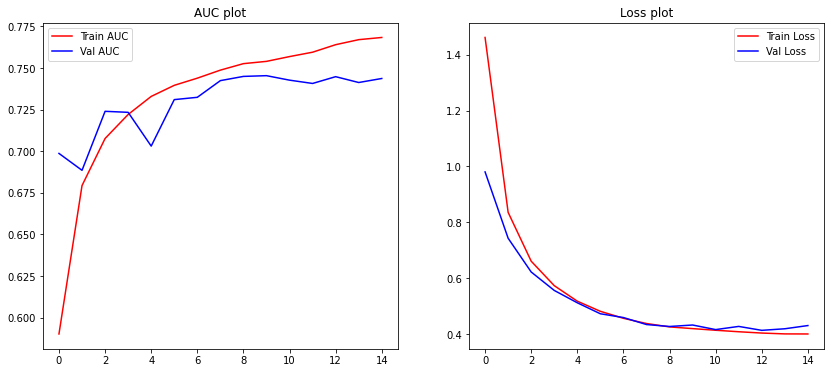

In [38]:
fig = plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.title('AUC plot')
plt.plot(train_model_2.history['auc'], 'r')
plt.plot(train_model_2.history['val_auc'], 'b')
plt.legend({'Train AUC': 'r', 'Val AUC':'b'})

plt.subplot(1, 2, 2)
plt.title('Loss plot')
plt.plot(train_model_2.history['loss'], 'r')
plt.plot(train_model_2.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Val Loss':'b'})
plt.show()

## Visualizing Model 

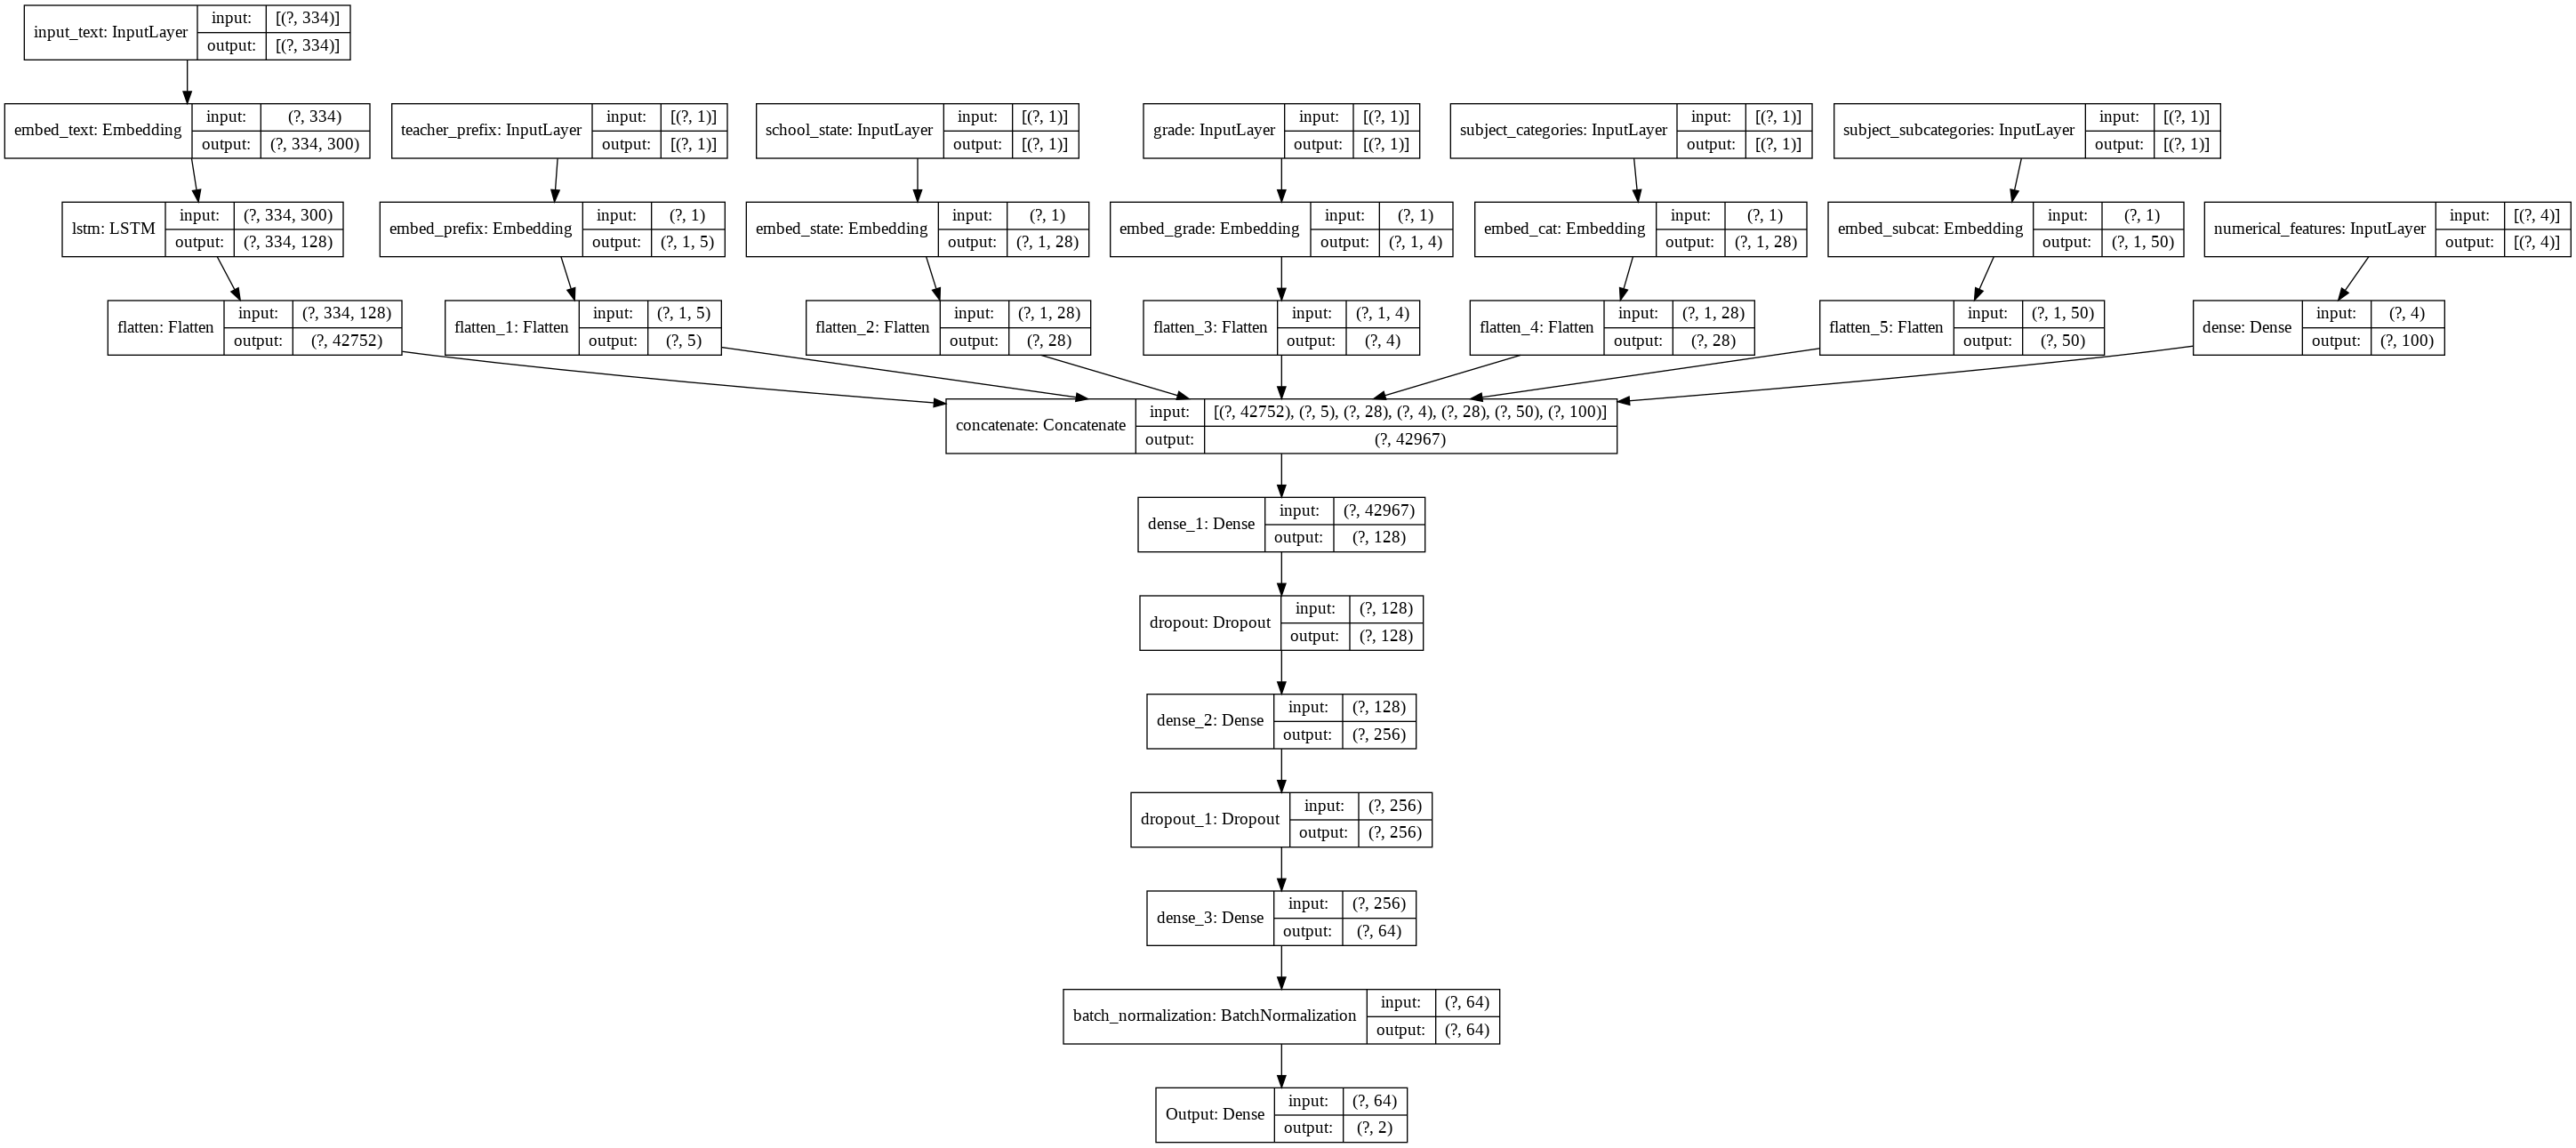

In [39]:
from IPython.display import Image
import pydot_ng as pydot

plot_model(model_2, show_shapes=True, show_layer_names=True, to_file='/content/drive/My Drive/LSTM/model_2.png')

## Tensorboard Plots

### Tensorboard AUC PLOT
<img src="auc.svg" width="600" height="400">

### Tensorboard LOSS PLOT
<img src="loss.svg" width="600" height="400">

__We get an AUC score of 74.01 on this LSTM model__